### 1. Import libraries

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.utils import make_grid

In [2]:
# unzip this file from drive .

import zipfile
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/speech_commands.zip'  # Replace with your actual path

# Specify the directory where you want to unzip the files
extract_dir = '/content/extracted_speech_commands' # Replace with your desired directory

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Successfully unzipped '{zip_file_path}' to '{extract_dir}'")
except FileNotFoundError:
    print(f"Error: Zip file not found at '{zip_file_path}'")
except zipfile.BadZipFile:
    print(f"Error: Invalid zip file at '{zip_file_path}'")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Mounted at /content/drive
Successfully unzipped '/content/drive/MyDrive/speech_commands.zip' to '/content/extracted_speech_commands'


### 2. Apply Image Transformations

In [3]:
default_dir = os.getcwd()
print("CURRENT DIR",os.getcwd())
path ='/content/extracted_speech_commands'
os.chdir(path)
print("UPDATED DIR",os.getcwd())
labels = [name for name in os.listdir('.') if os.path.isdir(name)]
print(f'Total Labels: {len(labels)} \n')
labels

CURRENT DIR /content
UPDATED DIR /content/extracted_speech_commands
Total Labels: 3 



['data', 'cat', 'dog']

In [4]:
train_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor()
])

In [5]:
train = ImageFolder('./data/spectrograms/', transform = train_transform)

In [6]:
train.classes

['cat', 'dog']

### 3. Split Our Data

In [7]:
val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(3328, 831)

In [8]:
batch_size = 64

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

### 4. Look Grid of Images

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

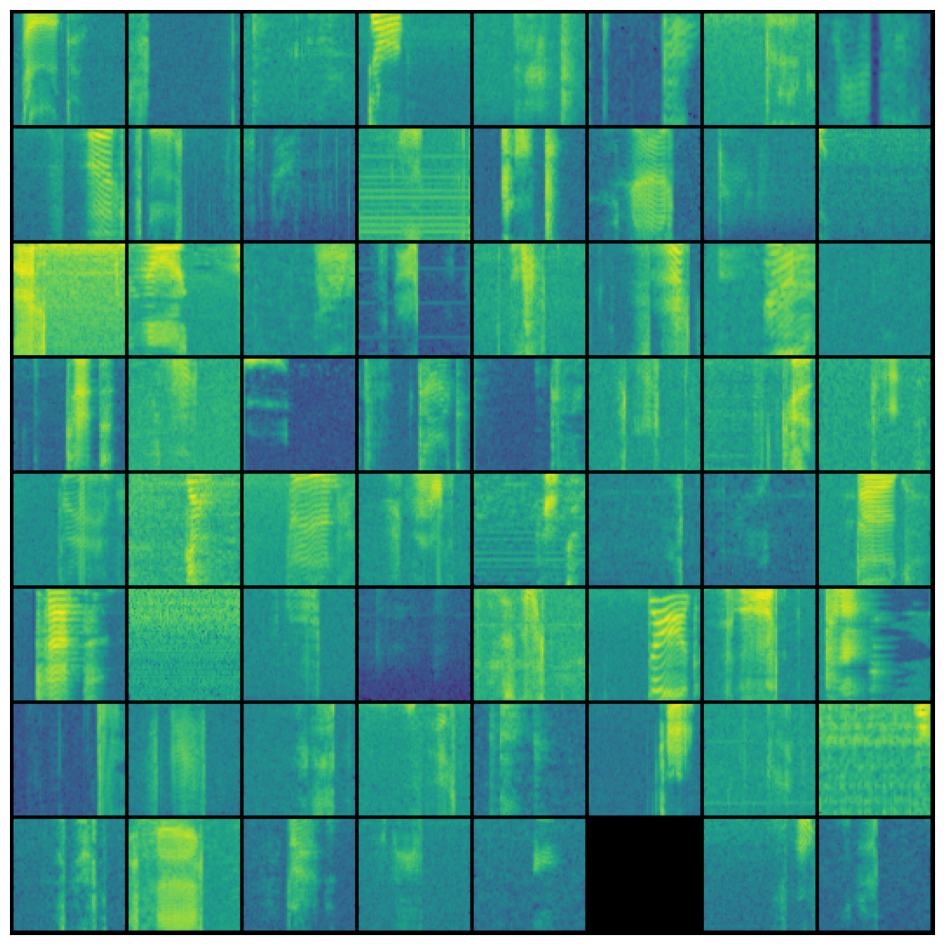

In [10]:
show_batch(train_dl)

### 5. Create Utility Functions for DeviceDataLoader

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### 6. Create Base Model

In [12]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss =  F.cross_entropy(out, labels)# Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss =  F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### 7. Creating a convolutional neural network (CNN)

In [15]:
#Creating a convolutional neural network (CNN)
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [16]:
no_of_classes = len(train.classes)
no_of_classes

2

In [17]:
model = to_device(ResNet9(3, no_of_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### 8. Train the Model

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.6931030750274658, 'val_acc': 0.5044111609458923}]

### 9. Define Hyper Parameters

In [20]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [21]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00149, train_loss: 0.9090, val_loss: 0.5518, val_acc: 0.7418
Epoch [1], last_lr: 0.00433, train_loss: 0.6618, val_loss: 3.3463, val_acc: 0.5134
Epoch [2], last_lr: 0.00758, train_loss: 0.8736, val_loss: 1.4951, val_acc: 0.5112
Epoch [3], last_lr: 0.00971, train_loss: 0.8074, val_loss: 1.1081, val_acc: 0.5044
Epoch [4], last_lr: 0.00994, train_loss: 1.0408, val_loss: 1.1179, val_acc: 0.5224
Epoch [5], last_lr: 0.00950, train_loss: 0.9305, val_loss: 0.8363, val_acc: 0.5134
Epoch [6], last_lr: 0.00867, train_loss: 0.7662, val_loss: 0.6058, val_acc: 0.7149
Epoch [7], last_lr: 0.00750, train_loss: 0.7061, val_loss: 0.7560, val_acc: 0.6545
Epoch [8], last_lr: 0.00611, train_loss: 0.6975, val_loss: 0.8667, val_acc: 0.7070
Epoch [9], last_lr: 0.00463, train_loss: 0.6482, val_loss: 0.9076, val_acc: 0.6276
Epoch [10], last_lr: 0.00317, train_loss: 0.6074, val_loss: 0.4777, val_acc: 0.7976
Epoch [11], last_lr: 0.00188, train_loss: 0.5223, val_loss: 0.6165, val_acc: 0.7194
Ep

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

### 10. Visualize Accuracies

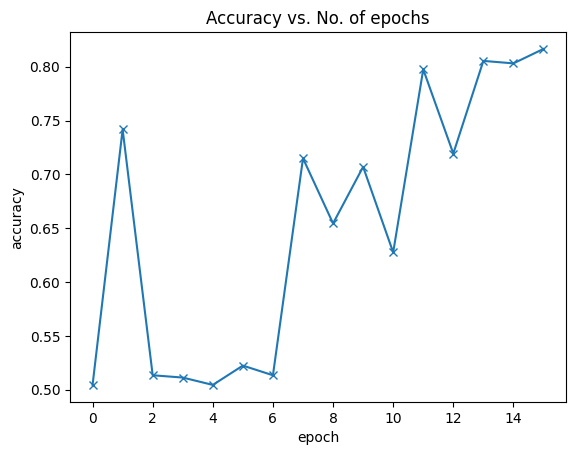

In [23]:
plot_accuracies(history)

### 11. Visualize Loss

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

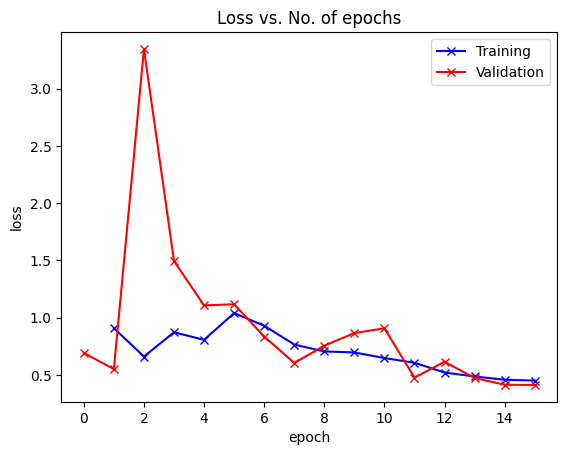

In [25]:
plot_losses(history)

### 12. Save and Load Our Model

In [26]:
torch.save(model.state_dict(), 'fit_model.pt')

In [27]:
model_load = to_device(ResNet9(3, no_of_classes), device)

In [28]:
model_load.load_state_dict(torch.load('fit_model.pt'))

<All keys matched successfully>

In [29]:
model_load.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### 13. Perform predictions

In [30]:
test = ImageFolder("./data/spectrograms/",transform = tt.ToTensor())

In [31]:
def predict_image(img, model):
    # Convert to a batch of 1
    ximg = to_device(img.unsqueeze(0), device)
    yimg = model(ximg)
    ## Picking the image with highest probability
    prob, preds  = torch.max(yimg, dim=1)
    # Getting the class label
    return test.classes[preds[0].item()]

0
Label: cat , Predicted: cat


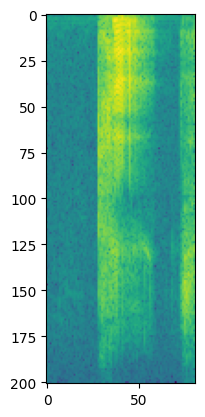

In [32]:
img, label = test[5]
plt.imshow(img.permute(1, 2, 0))
print(label)
print('Label:', test.classes[label], ', Predicted:', predict_image(img, model_load))